In [1]:
import pandas as pd
import numpy as np
import keras
from tqdm.notebook import tqdm
from IPython.display import display
import sklearn
from matplotlib import pyplot as plt
from keras.layers import LSTM, Dropout, Dense, BatchNormalization, TimeDistributed, Input, Masking, Embedding
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
#https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

In [2]:
def plot_roc_cur(fper, tper, label="", line="", title="plot title"):
    plt.plot(fper, tper, line, label=label)
    #plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    
def create_roc_curve(preds, targets, label="", line="", title=""):
    all_fpr, all_tpr = [], []
    fpr, tpr, thresholds = roc_curve(targets, preds)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_fpr = np.array(all_fpr)
    all_tpr = np.array(tpr)
    
    plot_roc_cur(all_fpr[0], all_tpr, label=label, line=line, title=title) 

To do:

- Load alle trials i stedte for data (all_readings = np.load('all_readings.npy', allow_pickle=True))
- Ryd op i de trials.
- Generér uniform trials (3D array med [batch, samples,features])
    - Altså, cellen med #Make all trials same length - Save this cell
    - batch er alle dine træningspunkter
    - samples er dine time series (små udklip af eye tracking)
    - features er... ja, features.
- Få LSTM til at virke med din data - skidevære med metrics.
- Når det virker kan du rode rundt med ordentlig klassifikation
- Evt separer saccades og fixations?

In [88]:
target = 'gender' #'age'
even_gender = False

sample_length = 8
batch_size=10

seed = 42

epochs=100
verbose=True


np.random.seed(seed) 

In [79]:
data = np.load('all_readings.npy', allow_pickle=True)
data = [i for i in data if len(i)>sample_length]

if even_gender:
    data = data[:-52]

In [80]:
def make_trials_uniform(trials):
    uniform_X = []
    uniform_y = []
    show = True
    for trial in tqdm(trials):
        X, y = cleanup_reading(trial, show=show)
        show=False
        length = X.shape[0]
        for i in range(sample_length, length-length%sample_length, sample_length):
            uniform_X.append(X.iloc[i-sample_length:i])
            uniform_y.append(y.values[0])
    
    return np.array(uniform_X), np.array(uniform_y)

def experimental(trial):    
    trial = trial[trial['eventType']==0]
    trial = trial.drop('eventType', axis=1)
    trial = trial.replace(0,np.nan).dropna(axis=1,how="all")
    return trial[['duration','meanPupilDiameter']]

def cleanup_reading(trial, show=False):
    trial = trial[trial.columns[1:]]
    trial = trial[trial['eye']=='left']
    trial = trial.drop('eye',1)
    trial = trial.drop('eventIdxLeft',1)
    trial = trial.drop('eventIdxRight',1)
    
    fixations = trial[trial['eventType']=='fixation']
    saccades = trial[trial['eventType']=='saccade']
    
    fixations = fixations.reset_index()
    fixations = fixations.drop(['startSaccadeX', 'startSaccadeY', 'endSaccadeX', 'endSaccadeY',
                                'age', 'gender', 'index', 'eventType'], axis=1)
    fixations = fixations.rename(columns={"duration": "fix_duration"})
    
    saccades = saccades.reset_index()
    saccades = saccades.drop(['meanX', 'meanY', 'microsaccadeCount', 'microsaccadeAmplitude', 'meanPupilDiameter',
                              'microsaccadePeakVelocity', 'index', 'eventType'], axis=1)
    saccades = saccades.rename(columns={"duration": "sac_duration"})
    
    trial = pd.concat([fixations, saccades], axis=1)
    feats = trial.columns
    trial = trial.reset_index()
    trial = trial.fillna(0)
    
    if show:
        print("Your features")
        display(trial.head())
        
    return trial[feats[:-2]], trial[feats[-2:]]

In [81]:
np.random.shuffle(data)
X,y = make_trials_uniform(data)
X,y = sklearn.utils.shuffle(X, y, random_state=seed)
y = y-1

if target == 'gender':
    y = y[:,0] #Only tage gender
else:
    y = y[:,1]

y = y.reshape(-1, 1)
print(f'X shape: {X.shape}, y shape: {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=seed)

  0%|          | 0/5604 [00:00<?, ?it/s]

Your features


,index,fix_duration,meanPupilDiameter,meanX,meanY,microsaccadeCount,microsaccadeAmplitude,microsaccadePeakVelocity,sac_duration,startSaccadeX,startSaccadeY,endSaccadeX,endSaccadeY,gender,age
0,0,184,3.972576,424.644213,354.011191,1.0,8.331842,21.142133,24,617.138,359.275,425.413,366.586,2.0,19.0
1,1,239,4.007568,475.469623,388.937262,0.0,0.000000,0.000000,8,430.143,389.097,470.964,389.097,2.0,19.0
2,2,460,3.971196,527.820621,386.600733,1.0,10.866820,30.656857,16,474.449,386.908,528.482,371.122,2.0,19.0
3,3,128,3.905687,854.527970,534.765970,0.0,0.000000,0.000000,40,525.930,381.571,837.258,507.402,2.0,19.0
4,4,208,3.900606,949.051208,515.684377,0.0,0.000000,0.000000,20,861.851,551.706,939.399,523.784,2.0,19.0


X shape: (7048, 8, 12), y shape: (7048, 1)


In [89]:
model = keras.Sequential()
model.add(Input(shape=(X_train[0].shape)))
model.add(BatchNormalization())
model.add(LSTM(46, return_sequences=True))
model.add(LSTM(600, return_sequences=True))
model.add(Dense(720, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy"
              , metrics=[keras.metrics.binary_accuracy]
              , optimizer="adam")


model.summary()

Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_106 (Bat (None, 8, 12)             48        
_________________________________________________________________
lstm_170 (LSTM)              (None, 8, 46)             10856     
_________________________________________________________________
lstm_171 (LSTM)              (None, 8, 600)            1552800   
_________________________________________________________________
dense_212 (Dense)            (None, 8, 720)            432720    
_________________________________________________________________
dropout_106 (Dropout)        (None, 8, 720)            0         
_________________________________________________________________
dense_213 (Dense)            (None, 8, 1)              721       
Total params: 1,997,145
Trainable params: 1,997,121
Non-trainable params: 24
_________________________________________

In [90]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, 
                         batch_size=batch_size, callbacks=[callback])

Epoch 1/100
476/476 [==============================] - 25s 53ms/step - loss: 0.6794 - binary_accuracy: 0.5778 - val_loss: 0.6606 - val_binary_accuracy: 0.6144
Epoch 2/100
476/476 [==============================] - 25s 52ms/step - loss: 0.6660 - binary_accuracy: 0.6014 - val_loss: 0.6524 - val_binary_accuracy: 0.6328
Epoch 3/100
476/476 [==============================] - 26s 54ms/step - loss: 0.6614 - binary_accuracy: 0.6086 - val_loss: 0.6631 - val_binary_accuracy: 0.6191
Epoch 4/100
476/476 [==============================] - 28s 58ms/step - loss: 0.6611 - binary_accuracy: 0.6127 - val_loss: 0.6528 - val_binary_accuracy: 0.6274
Epoch 5/100
476/476 [==============================] - 26s 55ms/step - loss: 0.6536 - binary_accuracy: 0.6200 - val_loss: 0.6571 - val_binary_accuracy: 0.6203
Epoch 6/100
476/476 [==============================] - 26s 54ms/step - loss: 0.6533 - binary_accuracy: 0.6198 - val_loss: 0.6569 - val_binary_accuracy: 0.6160
Epoch 7/100
476/476 [=========================

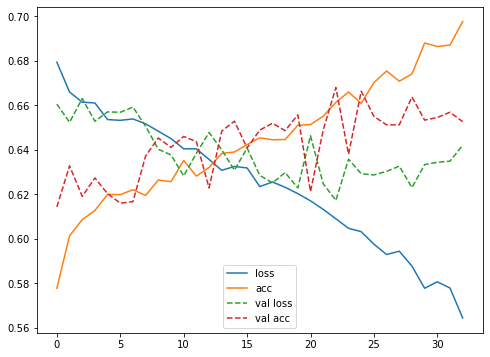

In [92]:
fig=plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label="loss");
plt.plot(history.history['binary_accuracy'], label="acc");
plt.plot(history.history['val_loss'], '--', label="val loss");
plt.plot(history.history['val_binary_accuracy'], '--', label="val acc");
plt.legend();

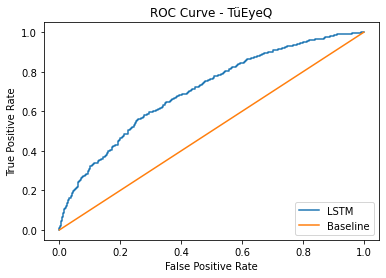

In [98]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

create_roc_curve(model.predict(X_test).mean(axis=1), y_test, label="LSTM")
create_roc_curve(dummy.predict(X_test), y_test, label="Baseline", title="ROC Curve - TüEyeQ")

In [18]:
model.evaluate(X_test, y_test)

56/56 [==============================] - 0s 2ms/step - loss: 0.6578 - accuracy: 0.6320


[0.6578251123428345, 0.6319523453712463]

In [ ]:
best_acc

In [36]:
accuracies = [i[1].history['val_accuracy'][-1] for i in models]

In [43]:
best = 0
best_ind = 0
best_model = None
for ind, model in enumerate(models):
    model = model[0]
    acc = model.evaluate(X_test, y_test)
    if acc[1] > best:
        best = acc[1]
        best_ind = ind
        best_model = model


56/56 [==============================] - 1s 12ms/step - loss: 0.7802 - accuracy: 0.6071


56/56 [==============================] - 1s 26ms/step - loss: 0.6764 - accuracy: 0.6265


In [45]:
best_model.summary() # Final architecture

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_32 (Batc (None, 8, 12)             48        
_________________________________________________________________
lstm_49 (LSTM)               (None, 8, 46)             10856     
_________________________________________________________________
lstm_50 (LSTM)               (None, 8, 600)            1552800   
_________________________________________________________________
dense_64 (Dense)             (None, 8, 720)            432720    
_________________________________________________________________
dropout_32 (Dropout)         (None, 8, 720)            0         
_________________________________________________________________
dense_65 (Dense)             (None, 8, 1)              721       
Total params: 1,997,145
Trainable params: 1,997,121
Non-trainable params: 24
__________________________________________

In [75]:
models[95][0].summary()

Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_98 (Batc (None, 8, 12)             48        
_________________________________________________________________
lstm_156 (LSTM)              (None, 8, 245)            252840    
_________________________________________________________________
lstm_157 (LSTM)              (None, 8, 109)            154780    
_________________________________________________________________
dense_196 (Dense)            (None, 8, 799)            87890     
_________________________________________________________________
dropout_98 (Dropout)         (None, 8, 799)            0         
_________________________________________________________________
dense_197 (Dense)            (None, 8, 1)              800       
Total params: 496,358
Trainable params: 496,334
Non-trainable params: 24
______________________________________________

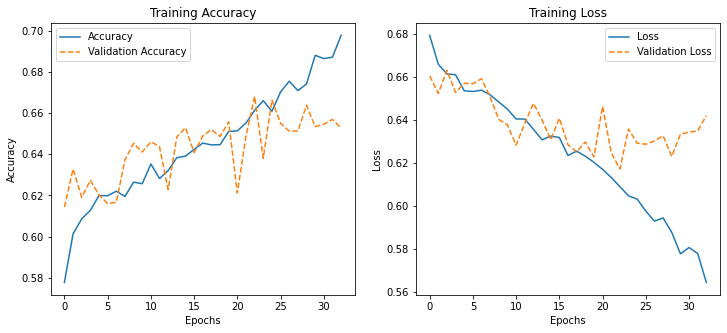

In [116]:
fig = plt.figure(figsize=(12,5))
hist = models[29][1].history
plt.subplot(1,2,1)
plt.title("Training Accuracy")
plt.plot(history.history['binary_accuracy'], label="Accuracy")
plt.plot(history.history['val_binary_accuracy'], '--', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.title("Training Loss")
plt.plot(history.history['loss'], label="Loss")
plt.plot(history.history['val_loss'], '--', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [117]:
model.evaluate(X_test,y_test)

56/56 [==============================] - 4s 76ms/step - loss: 0.6547 - binary_accuracy: 0.6283


[0.6547134518623352, 0.6283342838287354]

In [103]:
np.save('LSTM_tueyeq_pred', (model.predict(X_test).mean(axis=1), y_test))

In [115]:
#np.save('doves_turk', np.concatenate())

(582, 1)